In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [3]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [4]:
train_data = datasets.CIFAR10('data', train=True, download=True, transform=transform_train)
test_data = datasets.CIFAR10('data', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
num_workers=0
batch_size=50
valid_size=0.2

train_length = len(train_data)
indices=list(range(len(train_data)))
split = int(np.floor(valid_size * train_length))
np.random.shuffle(indices)

train_idx=indices[split:]
valid_idx=indices[:split]

train_sampler=SubsetRandomSampler(train_idx)
validation_sampler=SubsetRandomSampler(valid_idx)

train_loader=DataLoader(train_data,num_workers=num_workers,batch_size=batch_size,sampler=train_sampler)
valid_loader=DataLoader(train_data,num_workers=num_workers,batch_size=batch_size,sampler=validation_sampler)
test_loader=DataLoader(test_data,shuffle=True,num_workers=num_workers,batch_size=batch_size)

In [12]:
def showRGB(img):
    img=img*0.5+0.5
    plt.imshow(np.transpose(img,(1,2,0)))

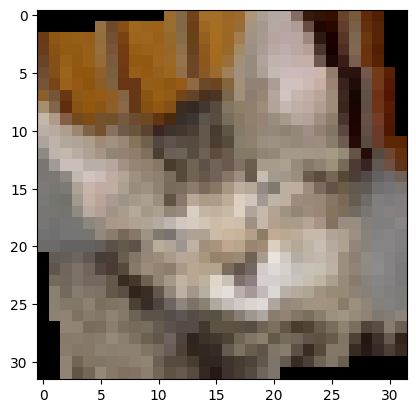

In [15]:
dataiter=iter(train_loader)
images,labels=next(dataiter)
showRGB(images[0])

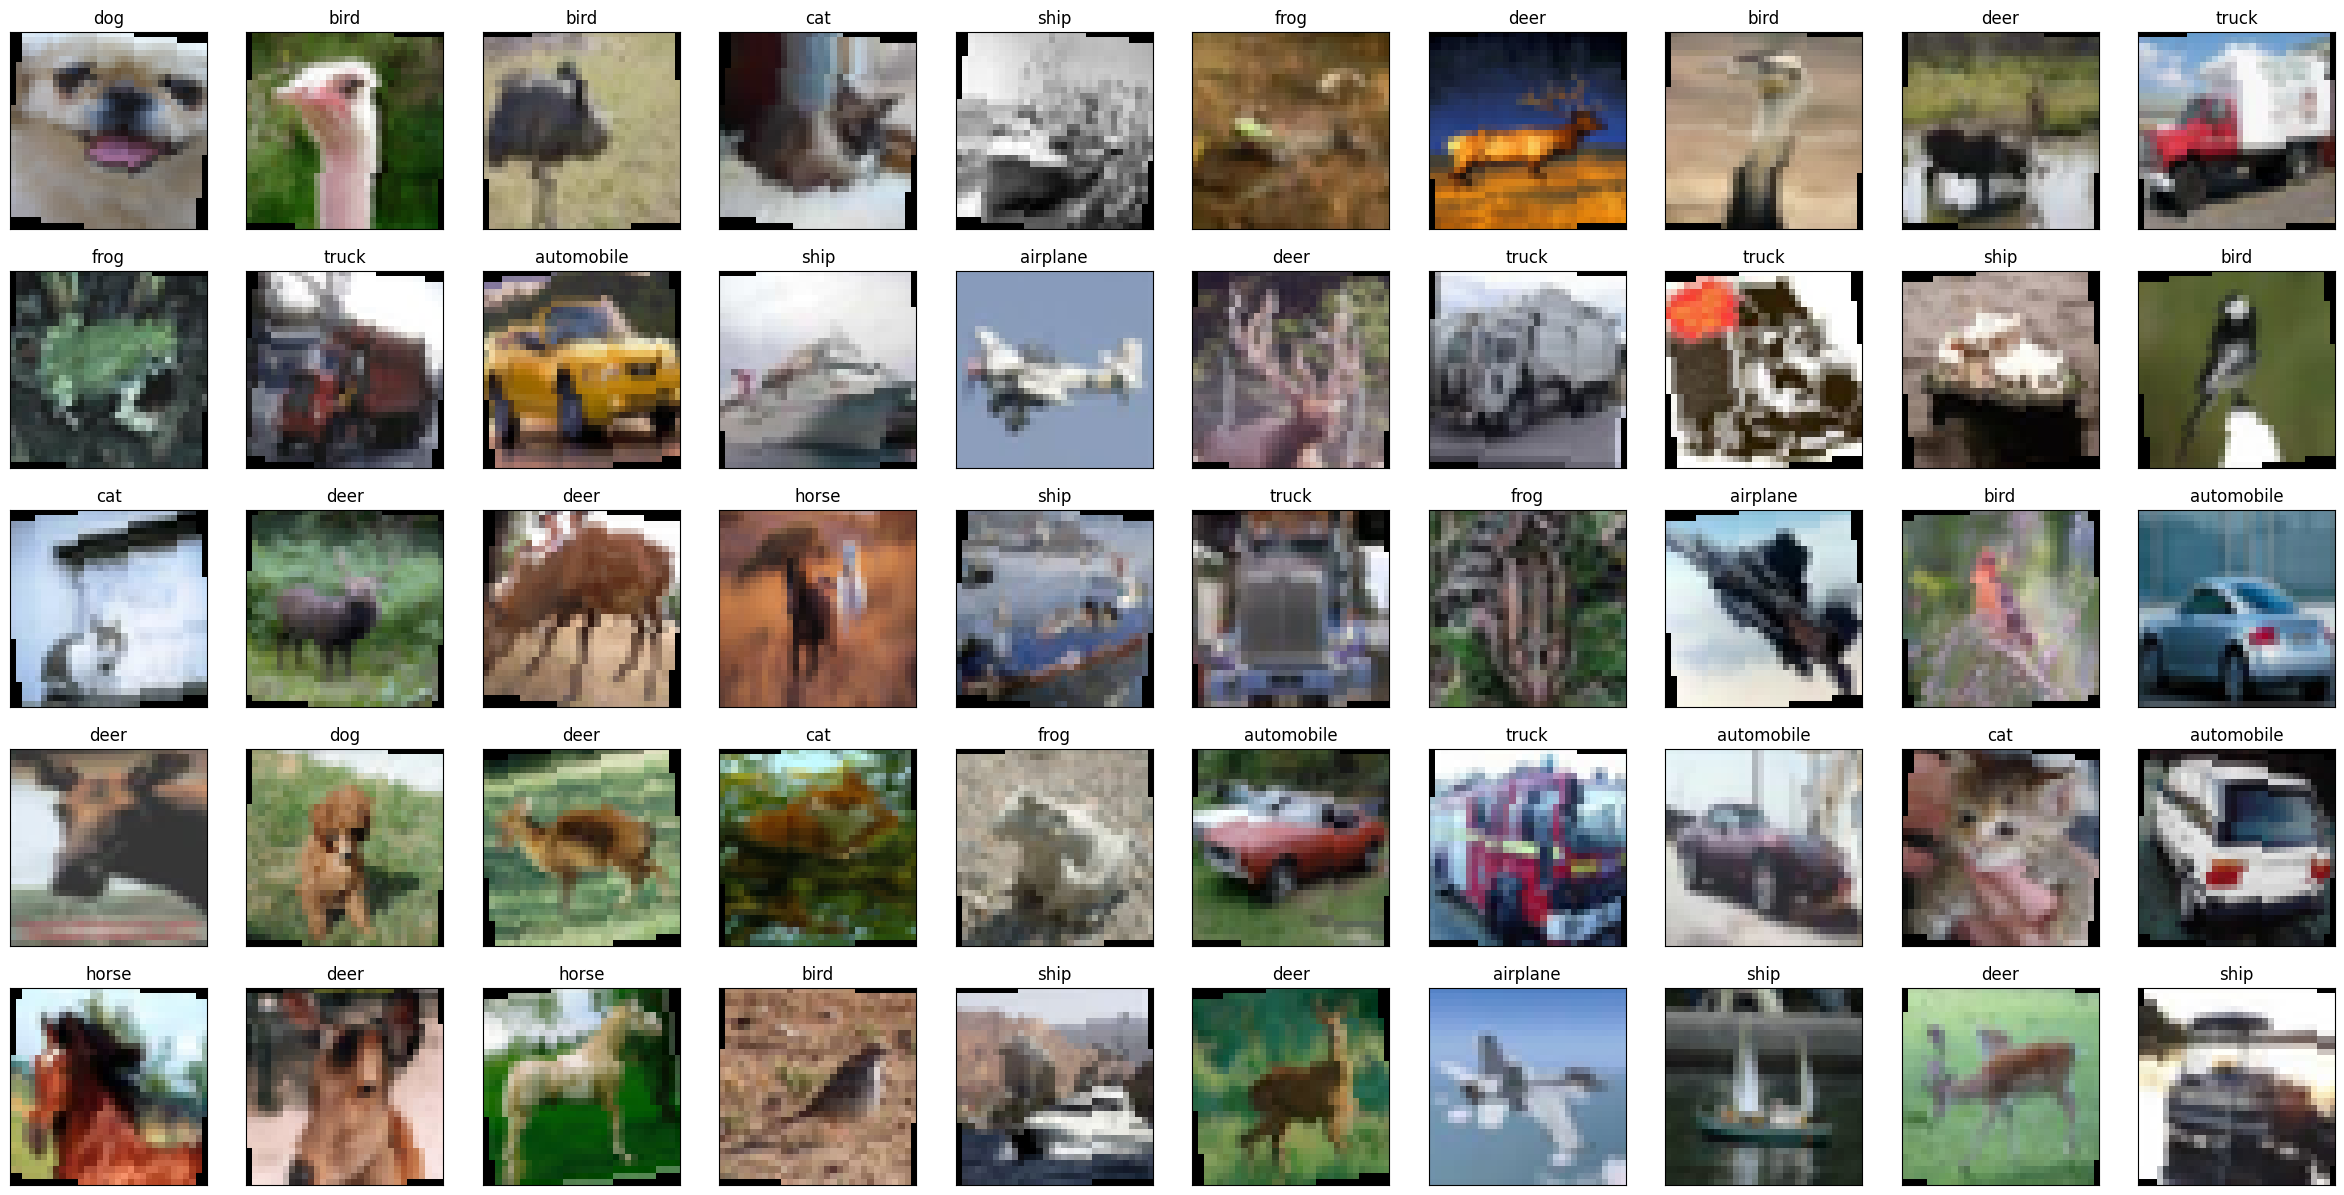

In [31]:
classes=['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

fig=plt.figure(1,figsize=(30,15))

for idx in range(batch_size):
    ax=fig.add_subplot(5, int(batch_size/5), idx+1, xticks=[], yticks=[])
    showRGB(images[idx])
    ax.set_title(classes[labels[idx]])

In [32]:
class convNet(nn.Module):
  def __init__(self):
    super(convNet, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.dropout = nn.Dropout(0.25)
    self.fc1 = nn.Linear(128*2*2, 256)
    self.fc2 = nn.Linear(256, 64)
    self.out = nn.Linear(64, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = self.pool(F.relu(self.conv4(x)))
    x = x.view(-1, 128*2*2)
    x = self.dropout(x)
    x = self.dropout(F.relu(self.fc1(x)))
    x = self.dropout(F.relu(self.fc2(x)))
    x = self.out(x)
    return x


def weight_init_normal(m):
  classname = m.__class__.__name__
  if classname.find('Linear') != -1:
    n = m.in_features
    y = (1.0/np.sqrt(n))
    m.weight.data.normal_(0, y)
    m.bias.data.fill_(0)


In [33]:
model = convNet()
use_cuda = True
if use_cuda and torch.cuda.is_available():
  model.cuda()

criterion = nn.CrossEntropyLoss()

In [ ]:
def trainNet(model, lr, trainer, validater):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  loss_keeper = {'train': [], 'valid': []}
  epochs = 50

  valid_loss_min = np.Inf

  for epoch in range(epochs):
    train_loss = 0.0
    valid_loss = 0.0

    """
    TRAINING PHASE
    """
    model.train()

    for images, labels in trainer:
      if use_cuda and torch.cuda.is_available():
        images, labels = images.cuda(), labels.cuda()
      optimizer.zero_grad()
      output = model(images)
      loss = criterion(output, labels)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()

    """
    VALIDATION PHASE
    """
    model.eval()

    for images, labels in validater:
      if use_cuda and torch.cuda.is_available():
        images, labels = images.cuda(), labels.cuda()
      output = model(images)
      loss = criterion(output, labels)
      valid_loss += loss.item()

    train_loss = train_loss/len(trainer)
    valid_loss = valid_loss/len(validater)

    loss_keeper['train'].append(train_loss)
    loss_keeper['valid'].append(valid_loss)

    print(f"\nEpoch : {epoch+1}\tTraining Loss : {train_loss}\tValidation Loss : {valid_loss}")

    if valid_loss <= valid_loss_min:
      print(f"Validation loss decreased from : {valid_loss_min} ----> {valid_loss} ----> Saving Model.......")
      z = type(model).__name__
      torch.save(model.state_dict(), z+'_model.pth')
      valid_loss_min = valid_loss
  return (loss_keeper)


In [ ]:
model_loss = trainNet(model, 0.001, train_loader, valid_loader)
print(model_loss)